In [240]:
import os
import pandas as pd
import numpy as np

In [241]:
df_u = pd.read_csv('tmp/df_users_contacts_final.csv', index_col=0)
df_vl = pd.read_csv('tmp/df_view_logs_uam_final.csv', index_col=0) 

In [242]:
# merge and remove nan sl_success
df_vl_u = pd.merge(df_vl, df_u, right_on='user_id', left_on='user_id_aug', how='left')
df_vl_u = df_vl_u.loc[~df_vl_u['sl_success'].isnull()]

# add pre activation flag 
df_vl_u['pre_activation'] = df_vl_u['vl_created_at'] < df_vl_u['user_activated_at']

# keep only preactivation 
df_vl_pre = df_vl_u.loc[df_vl_u['pre_activation']]

# keep only commercial for now
df_vl_comm = df_vl_pre.loc[df_vl_pre['commercial'] == 1]

In [243]:
df_sls = df_vl_comm.loc[df_vl_comm['sl_success'] == 1]
df_no_sls = df_vl_comm.loc[df_vl_comm['sl_success'] == 0]

In [244]:
df_sls.head()

,vl_created_at,user_id_aug,url,user_id,user_activated_at,commercial,sl_success,pre_activation
101,2022-01-01 16:56:20.989838,170667,signup,170667.0,2022-01-01 17:10:38,1.0,1.0,True
102,2022-01-01 16:56:55.627038,170667,lab-automation,170667.0,2022-01-01 17:10:38,1.0,1.0,True
103,2022-01-01 16:59:23.497364,170667,parts-library,170667.0,2022-01-01 17:10:38,1.0,1.0,True
104,2022-01-01 17:02:11.510151,170667,parts-library,170667.0,2022-01-01 17:10:38,1.0,1.0,True
105,2022-01-01 17:02:37.019057,170667,parts,170667.0,2022-01-01 17:10:38,1.0,1.0,True


In [245]:
print(len(df_sls['user_id_aug'].unique()))
print(len(df_no_sls['user_id_aug'].unique()))

10066
12267


In [246]:
df_sls = df_sls.sort_values(['user_id_aug', 'vl_created_at'])
df_no_sls = df_no_sls.sort_values(['user_id_aug', 'vl_created_at'])

df_uj_sls = df_sls.groupby('user_id_aug')['url'].apply(lambda x: ' '.join(x)).reset_index()
df_uj_no_sls = df_no_sls.groupby('user_id_aug')['url'].apply(lambda x: ' '.join(x)).reset_index()

In [247]:
journey_corpus_sls = list(df_uj_sls['url'])
journey_corpus_no_sls = list(df_uj_no_sls['url'])

In [248]:
dataset = pd.DataFrame({'X': journey_corpus_sls + journey_corpus_no_sls, 'y': [1]*len(journey_corpus_sls) + [0]*len(journey_corpus_no_sls)})
dataset_no_sls = dataset.loc[dataset['y'] == 0].sample(len(journey_corpus_sls))
dataset_sls = dataset.loc[dataset['y'] == 1]
dataset_balanced = pd.concat([dataset_no_sls, dataset_sls], axis=0)
dataset_balanced.reset_index(drop=True, inplace=True)

In [249]:
X2 = dataset_balanced['X'].apply(lambda x: len(x.split(' ')))
dataset_balanced['X2'] = X2
dataset_balanced

,X,y,X2
0,users dashboard users users users users users ...,0,11
1,probable-source-google-campaign signup users,0,3
2,probable-source-google-campaign signup users,0,3
3,probable-source-google-campaign probable-sourc...,0,4
4,robot-home signup robot-home users signup users,0,6
...,...,...,...
20127,probable-source-google-campaign signup verify-...,1,4
20128,3d-design signup verify-email users,1,4
20129,3d-design 3d-design vention.io signup verify-e...,1,6
20130,vention.io customer-stories 3d-design vention....,1,7


In [250]:
# Training the classifier, predicting on test data & evaluating performance with classification metrics

# Spliting into X & y
# X = dataset_balanced.iloc[:, 2].values.reshape((dataset_balanced.shape[0], 1))
X = dataset_balanced.iloc[:, 0].values
y = dataset_balanced.iloc[:, 1].values

# Building a TF IDF matrix out of the corpus of reviews
from sklearn.feature_extraction.text import TfidfVectorizer
td = TfidfVectorizer(max_features = 4500)
X = td.fit_transform(X).toarray()

# Splitting into training & test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

# Training the classifier & predicting on test data
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
y_proba = classifier.predict_proba(X_test)

# Classification metrics
from sklearn.metrics import accuracy_score, classification_report
classification_report = classification_report(y_test, y_pred)

print('\n Accuracy: ', accuracy_score(y_test, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)


 Accuracy:  0.575

Classification Report

               precision    recall  f1-score   support

           0       0.57      0.66      0.61      3035
           1       0.59      0.49      0.54      3005

    accuracy                           0.57      6040
   macro avg       0.58      0.57      0.57      6040
weighted avg       0.58      0.57      0.57      6040



In [251]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1988, 1047],
       [1520, 1485]], dtype=int64)

In [252]:
# Training the classifier, predicting on test data & evaluating performance with classification metrics

# Spliting into X & y
# X = dataset_balanced.iloc[:, 2].values.reshape((dataset_balanced.shape[0], 1))
X = dataset.iloc[:, 0].values
y = dataset.iloc[:, 1].values

# Building a TF IDF matrix out of the corpus of reviews
from sklearn.feature_extraction.text import TfidfVectorizer
# td = TfidfVectorizer(max_features = 4500)
X = td.transform(X).toarray()

y_pred = classifier.predict(X)
y_proba = classifier.predict_proba(X)

# Classification metrics
from sklearn.metrics import accuracy_score, classification_report
classification_report = classification_report(y, y_pred)

print('\n Accuracy: ', accuracy_score(y, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)


 Accuracy:  0.6475619039090136

Classification Report

               precision    recall  f1-score   support

           0       0.66      0.72      0.69     12267
           1       0.62      0.56      0.59     10066

    accuracy                           0.65     22333
   macro avg       0.64      0.64      0.64     22333
weighted avg       0.65      0.65      0.64     22333



In [253]:
sls_proba = pd.DataFrame({'sls': y, 'sls_prob': y_proba[:,1].tolist()})
sls_proba = sls_proba.sort_values('sls_prob').reset_index(drop=True)
sls_proba_1 = sls_proba.loc[sls_proba['sls'] == 1]
sls_proba_0 = sls_proba.loc[sls_proba['sls'] == 0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


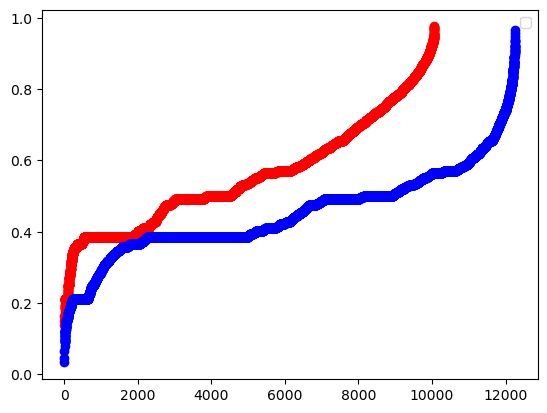

In [254]:
import matplotlib.pyplot as plt
plt.scatter(list(range(0, sls_proba_1.shape[0])), sls_proba_1['sls_prob'], c="red")
plt.scatter(list(range(0, sls_proba_0.shape[0])), sls_proba_0['sls_prob'], c="blue")
plt.legend()
plt.show()

In [255]:
sls_proba_1['sls_prob'].mean()
sls_proba_0['sls_prob'].mean()

0.45178274424514164

In [256]:
sls_proba

,sls,sls_prob
0,0,0.032998
1,0,0.046767
2,0,0.064834
3,0,0.080310
4,0,0.089400
...,...,...
22328,1,0.969618
22329,1,0.970756
22330,1,0.973791
22331,1,0.975158


In [257]:
for t in [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    print("sl success excluded", sls_proba.loc[sls_proba['sls_prob']<t, 'sls'].mean())
    print("sl success routed", sls_proba.loc[sls_proba['sls_prob']>=t, 'sls'].mean())
    print("% volume", sls_proba.loc[sls_proba['sls_prob']>=t, 'sls'].count()/sls_proba.shape[0])
    print("==============================================================\n")

sl success excluded nan
sl success routed 0.45072314512156897
% volume 1.0

sl success excluded 0.0
sl success routed 0.4509654585368039
% volume 0.999462678547441

sl success excluded 0.015625
sl success routed 0.45197359558130135
% volume 0.9971342855863521

sl success excluded 0.055
sl success routed 0.45429901052726696
% volume 0.9910446424573501

sl success excluded 0.13053097345132744
sl success routed 0.46423071538569227
% volume 0.9595217839072225

sl success excluded 0.14087947882736157
sl success routed 0.4687514806917792
% volume 0.9450141046881296

sl success excluded 0.14727374929735806
sl success routed 0.4769874476987448
% volume 0.9203420946581292

sl success excluded 0.27773155851358844
sl success routed 0.5332319291052179
% volume 0.677069807012045

sl success excluded 0.28877482704753404
sl success routed 0.5592700620746391
% volume 0.5987104285138584

sl success excluded 0.33533113575067425
sl success routed 0.6221480244852532
% volume 0.4023194376035463

sl success